In [2]:
#                            exchange between
#        ---------------------     tau_pw        -------------------------
#        |      plasma       |   -------->       |        wall           |
#        |                   |                   |                       |
#        |       N_p         |      tau_wp       |        N_w            |
#        |                   |   <--------       |                       |
#        ---------------------                   -------------------------
#
#            ^          |
#            |          |
#            |          |
#            |          v
#         seeding     tau_p
#         Gamma_s    pump loss
#
#        d/dt N_p = Gamma_s + N_w * tau_wp - N_p * (tau_pw * f + tau_p)
#        d/dt N_w = (N_p * tau_pw) * f - N_w * tau_wp
#
#
#            lim       d/dt N_w == 0 = N_p * tau_pw * f - Nwlim * tau_wp
#        N_w -> N_wlim
#                        ---> f = (N_wlim * tau_wp) / (N_p * tau_pw)
#
#
#        d/dt N_w = (N_wlim - N_w) * tau_wp
#        d/dt N_p = Gamma_s + N_w * tau_wp - N_wlim * tau_wp N_p - N_p * tau_p
# 
#
# another try: puff into second wall
# ------------------------------------------
#                                exchange between                       exchange between
#        ---------------------         tau_ps        ----------------       tau_sw         -------------------------
#        |      plasma       |        -------->      |    SOL       |     --------->       |        wall           |
#        |                   |                       |              |                      |                       |
#        |       N_p         |          tau_sp       |     N_s      |       tau_ws         |        N_w            |
#        |                   |        <--------      |              |     <----------      |                       |
#        ---------------------                       ----------------                      -------------------------
#
#                                                      ^          |
#                                                      |          |
#                                                      |          |
#                                                      |          v
#                                                   seeding     tau_p
#                                                   Gamma_s    pump loss
# 
#        d/dt N_w = (N_s * tau_sw) * fw - N_w * tau_ws
#        d/dt N_s = Gamma_s + N_p * tau_ps * fp - N_s * (tau_sw * fw + tau_sp + tau_s)
#        d/dt N_p = N_s * tau_sp - N_p * tau_ps * fp
# 
# 
#        lim        d/dt N_w == 0 = N_s * tau_sw * fw - N_wlim * tau_ws
#    N_w --> N_wlim
#                   ---> fw = (N_wlim * tau_ws) / (N_s * tau_sw)
#
#        lim        d/dt N_p == 0 = N_s * tau_sp - N_plim * tau_ps * fp
#    N_p --> N_plim
#                   ---> fp = (N_s * tau_sp) / (N_plim * tau_ps)
#
#
#        d/dt N_w = (N_s * tau_sw) * fw - N_w * tau_ws
#                 = (N_s * tau_sw) * (N_wlim * tau_ws) / (N_s * tau_sw) - N_w * tau_ws
#                 = (N_wlim - N_w) * tau_ws
#        d/dt N_s = Gamma_s + N_p * tau_ps * fp - N_s * (tau_sw * fw + tau_sp + tau_s)
#                 = Gamma_s + N_p * tau_ps * (N_s * tau_sp) / (N_plim * tau_ps) -
#                   N_s * (tau_sw * (N_wlim * tau_ws) / (N_s * tau_sw) + tau_sp + tau_s)
#                 = Gamma_s + N_p * N_s * tau_sp / N_plim - N_wlim * tau_ws - N_s * (tau_sp + tau_s)
#
#        d/dt N_p = N_s * tau_sp - N_p * fp
#                 = N_s * tau_sp - N_p * (N_s * tau_sp) / (N_plim * tau_ps)
#                 = N_s * tau_sp - (N_p * N_s * tau_sp) / (N_plim * tau_ps)
#

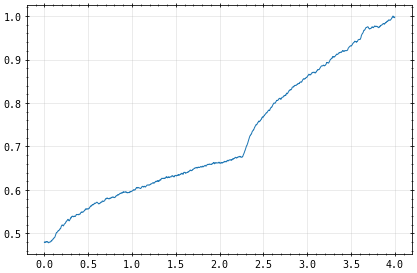

In [2]:
import os
import json
import sys

import matplotlib as mpl
import matplotlib.pyplot as p
from matplotlib.pyplot import cm

import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import odeint, solve_ivp

import logbook_api as logbook_api
import webapi_access as api
import dat_lists

os.chdir('//share.ipp-hgw.mpg.de//documents//pih//Documents//git//QSB_Bolometry//results//')

def y1(
        z, t, a, b, c, d):
    """ d/dt N_p = Gamma_s + N_w * tau_wp - N_wlim * tau_wp - N_p * tau_p
        d/dt N_w = (N_wlim - N_w) * tau_wp """

    # Gamma_s  tau_wp   N_wlim  tau_p 
    #   a       b          c      d
    x, y = z  # N_p, N_w
    return [
        a + y * b - d * b - c * b - x * d,
        (c - y) * b]

def y2(z, t, a, b, c, d, e, f, g):
    """ d/dt N_p = N_s * tau_sp - (N_p * N_s * tau_sp) / (N_plim * tau_ps)
        d/dt N_s = Gamma_s + N_p * N_s * tau_sp / N_plim - N_wlim * tau_ws - N_s * (tau_sp + tau_s)
        d/dt N_w = (N_wlim - N_w) * tau_ws """

    # tau_sp  N_plim  tau_ps  Gamma_s  N_wlim   tau_ws   tau_s
    #   a        b      c       d        e       f        g
    u, v, w = z  # N_p, N_s, N_w
    return [
        v * a - (u * v * a) / (b * c),
        d + u * v * a / (b) - e * f - b * c - v * (a + g),
        (e - w) * f]

program = '20180920.49'  # '20181016.023'
a0, a1, a2 = 4.2, 6.4, 8.2  # 3.1, 5., 7.

# xp info
program_info, req = api.xpid_info(program=program)
start = str(program_info['programs'][0]['from'])
stop = str(program_info['programs'][0]['upto'])

# triggers
t0 = program_info['programs'][0]['trigger']['1'][0]  # in ns
t4 = program_info['programs'][0]['trigger']['4'][0]  # in ns

# get prad traces for fitting of equations
obj = api.download_single(
    api.download_link(name='PradHBCm'),
    program_info=program_info,
    start_POSIX=start, stop_POSIX=stop)
s = np.array([(v - t0) / 1.e9 for v in obj['dimensions']])
u = np.array([v / 1.e6 for v in obj['values']])

T = s[np.where((s > .0) & (s < 10.))[0]]
V = u[np.where((s > .0) & (s < 10.))[0]]
p.plot(s[np.where((s > a0) & (s < a2))[0]] - s[np.where((s > a0) & (s < a2))[0]][0],
       u[np.where((s > a0) & (s < a2))[0]] / u[np.where((s > a0) & (s < a2))[0]].max())

In [3]:
def y1_solve(
    t=None, args=None, y0=None,
    c1='k', c2='r', ax=None):
    # ODE solve
    solution = odeint(
        func=y1, y0=y0, t=t, args=args,
        printmessg=True, tfirst=False)
    # plot
    if ax is not None:
        p1, = ax.plot(t, solution[:, 0], c=c1)
        p2, = ax.plot(t, solution[:, 1], c=c2)
        return (solution, ax, p1, p2)
    return (solution)

In [20]:
t = np.linspace(.0, 10., 101)
N = 10

norm = mpl.colors.Normalize(vmin=0, vmax=N)
C1 = mpl.colors.LinearSegmentedColormap.from_list(
    'mycolors', ['lightgrey', 'red'])
C2 = mpl.colors.LinearSegmentedColormap.from_list(
    'mycolors', ['lightgrey', 'blue'])

C1 = cm.ScalarMappable(cmap=C1, norm=norm)
C2 = cm.ScalarMappable(cmap=C2, norm=norm)

C1.set_array([])
C2.set_array([])

fig, ax = p.subplots()
#  ax.set_title(
#     '$\Gamma_{s}=10.$, $\\tau_{wp}=1.$, ' +
#     '$N_{w,lim}=10.$, $\\tau_{p}=1.$, $N_{w0}\in[0, 19]$')

vlist = []
for i, f in enumerate(np.linspace(.0, 1.9, N)):
    #      Gamma_s   tau_wp   N_wlim      tau_p 
    #         a       b          c          d
    args = ( 10.,     1.,     10.,       1.)
    #               N_p0         N_w0
    y00 = np.array([ 10.,      10.*f ])

    # values for colors
    vlist.append(1.*f)
    # colors
    c1 = C1.to_rgba(i)
    c2 = C2.to_rgba(i)

    _, ax, l1, l2 = y1_solve(
       t=t, args=args, y0=y00,
       c1=c1, c2=c2, ax=ax)
    if i == N - 5:
        ax.legend([l1, l2], ['N$_{p}$', 'N$_{w}$'])

norm = mpl.colors.Normalize(
    vmin=np.min(vlist), vmax=np.max(vlist))
c_m = mpl.colors.LinearSegmentedColormap.from_list(
    'mycolors', ['lightgrey', 'red'])
s_m = cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

cbar_ax = fig.add_axes([.975, 0.21, 0.03, 0.72])
fig.colorbar(s_m, cax=cbar_ax)
cbar_ax.set_ylabel(
    'N$_{w,0}$ [a.u.]')
    # 'N$_{p,0}$ [a.u.]')
    # '$\\Gamma_{s}$ [a.u.]')
    # '$\\tau_{w,p}$ [a.u.]')
    # 'N$_{w,lim}$ [a.u.]')
    # '$\\tau_{p}$ [a.u.]')

ax.set_xlabel('time [a.u.]')
ax.set_ylabel('N$_{p}$, N$_{w}$ [a.u.]')

fig.set_size_inches(4., 2.5)
fig.savefig(
    'twochamber_N_w0_scan.pdf')
    # 'twochamber_N_p0_scan.pdf')
    # 'twochamber_gammas_scan.pdf')
    # 'twochamber_tauwp_scan.pdf')
    # 'twochamber_Nwlim_scan.pdf')
    # 'twochamber_taup_scan.pdf')
fig.savefig('CURRENT/chamber_scan.pdf')
p.close('all')

C:\Users\pih\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:250: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)
ipykernel_launcher:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
ipykernel_launcher:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [9]:
def y2_solve(
    t=None, args=None, y0=None,
    c1='k', c2='r', c3='g', ax=None):
    # ODE solve
    solution = odeint(
        func=y2, y0=y00, t=t, args=args,
        printmessg=True, tfirst=False)
    # plot
    if ax is not None:
        p1, = ax.plot(t, solution[:, 0], c=c1)
        p2, = ax.plot(t, solution[:, 1], c=c2)
        p3, = ax.plot(t, solution[:, 2], c=c3)
        return (solution, ax, p1, p2, p3)
    return (solution)

In [10]:
t = np.linspace(.0, 10., 101)
N = 10

norm = mpl.colors.Normalize(vmin=0, vmax=N)
C1 = mpl.colors.LinearSegmentedColormap.from_list(
    'mycolors', ['lightgrey', 'red'])
C2 = mpl.colors.LinearSegmentedColormap.from_list(
    'mycolors', ['lightgrey', 'blue'])
C3 = mpl.colors.LinearSegmentedColormap.from_list(
    'mycolors', ['lightgrey', 'green'])

C1 = cm.ScalarMappable(cmap=C1, norm=norm)
C2 = cm.ScalarMappable(cmap=C2, norm=norm)
C3 = cm.ScalarMappable(cmap=C3, norm=norm)

C1.set_array([])
C2.set_array([])
C3.set_array([])

fig, ax = p.subplots()
# ax.set_title(
#     '$\\tau_{sp}=1.$, $N_{p,lim}=10$, $\\tau_{ps}=0.7$, ' +
#     '$\Gamma_{s}=20$, $N_{w,lim}=5$\n$\\tau_{ws}=1.$, ' +
#     '$\\tau_{s}=1.$, N$_{p,0}$=0, N$_{s,0}=1.$, N$_{wm,0}$=0')

vlist = []
for i, f in enumerate(np.linspace(.0, 2., N)):
    #      tau_sp  N_plim  tau_ps  Gamma_s  N_wlim   tau_ws   tau_s
    args = (  1.,   10.,     .7,    20.,       5.,    1.,     1.)
    #               N_p0     N_s0     N_w0
    y00 = np.array([ .0,     1.*f,     .0])

    # values for colors
    vlist.append(
        # 1.*f)
        # 1.*f)
        # 5.*f)
        # 20.*f)
        # .7*f)
        # 10.*f)
        1.*f)
        # 1.*f)

    c1 = C1.to_rgba(i)
    c2 = C2.to_rgba(i)
    c3 = C3.to_rgba(i)

    _, ax, l1, l2, l3 = y2_solve(
        t=t, args=args, y0=y00,
        c1=c1, c2=c2, c3=c3, ax=ax)
    if i == N - 5:
        ax.legend(
            [l1, l2, l3],
            ['N$_{p}$', 'N$_{s}$', 'N$_{w}$'])

ax.set_xlabel('time [a.u.]')
ax.set_ylabel('N$_{p}$, N$_{s}$, N$_{w}$ [a.u.]')

norm = mpl.colors.Normalize(
    vmin=np.min(vlist), vmax=np.max(vlist))
c_m = mpl.colors.LinearSegmentedColormap.from_list(
    'mycolors', ['lightgrey', 'red'])
s_m = cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

cbar_ax = fig.add_axes([.975, 0.21, 0.03, 0.72])
fig.colorbar(s_m, cax=cbar_ax)
cbar_ax.set_ylabel(
    # '$\\tau_{s}$ [a.u.]')
    # '$\\tau_{w,s}$ [a.u.]')
    # 'N$_{w,lim}$ [a.u.]')
    # '$\\Gamma_{s}$ [a.u.]')
    # '$\\tau_{p,s}$ [a.u.]')
    # 'N$_{p,lim}$ [a.u.]')
    # '$\\tau_{s,p}$ [a.u.]')
    'N$_{s,0}$ [a.u.]')

fig.set_size_inches(4., 2.5)
fig.savefig(
    # 'threechamber_taus_scan.pdf')
    # 'threechamber_tauws_scan.pdf')
    # 'threechamber_Nwlim_scan.pdf')
    # 'threechamber_gammas_scan.pdf')
    # 'threechamber_taups_scan.pdf')
    # 'threechamber_Nplim_scan.pdf')
    # 'threechamber_tausp_scan.pdf')
    'threechamber_N_s0_scan.pdf')
fig.savefig('CURRENT/chamber_scan.pdf')
p.close('all')

ipykernel_launcher:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
ipykernel_launcher:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


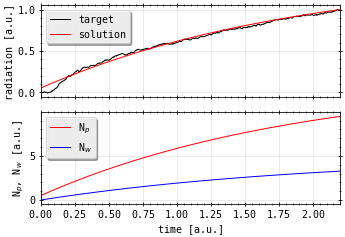

In [11]:
def integrator(x, a, b, c, d, y00, y01):
    sol = y1_solve(
        x, (a, b, c, d),
        (y00, y01))
    return (sol[:, 0] / sol[:, 0].max())

#         Gamma_s   tau_wp   N_wlim      tau_p    N_p0       N_w0
#            a       b          c          d       y00        y01
args = (    10.,     1.,       3.,        1.,      5.,        .0 )
b    = ([   5.,      .4,       1.,        .7,      .5,        .0],
        [   10.,     10.,      5.,       10.,     np.inf,    .1])

T = s[(s > a0) & (s < a1)]
V = u[(s > a0) & (s < a1)]

L = T - T[0]
G = (V - V[0]) / (V.max() - V[0])

res, pcov = curve_fit(
    integrator, L, G,
    p0=args, bounds=b)
# print('res:', res)

ch2_res = integrator(
    L, res[0], res[1], res[2], res[3], res[4], res[5])
s1 = odeint(
    func=y1, y0=[res[4], res[5]],
    t=T, args=(res[0], res[1], res[2], res[3])) 

fig, axes = p.subplots(2, 1, sharex=True)
axes[0].plot(L, G, c='k', label='target')
axes[0].plot(L, ch2_res, c='r', label='solution')
axes[1].plot(L, s1[:, 0], c='r', label='N$_{p}$')
axes[1].plot(L, s1[:, 1], c='b', label='N$_{w}$')

for ax in axes:
    ax.legend()
axes[1].set_xlabel('time [a.u.]')
axes[0].set_ylabel('radiation [a.u.]')
axes[1].set_ylabel('N$_{p}$, N$_{w}$ [a.u.]')
axes[1].set_xlim(.0, 2.2)

# title = ''
# for pr, v in zip([
#         '$\Gamma_{s}$', '$\\tau_{w,p}$', '$N_{w,lim}$',
#         '$\\tau_{w,p}$', '$N_{p,0}$', '$N_{w,0}$'], res):
#     title += pr + '=' + format(v, '.2f') + ', '

# fig.suptitle(
#     t=title,
#     x=.5, y=1.)

fig.set_size_inches(5., 3.5)
fig.savefig('chamber_simulation_one_stage.pdf')
fig.savefig('CURRENT/chamber_simulation.pdf')

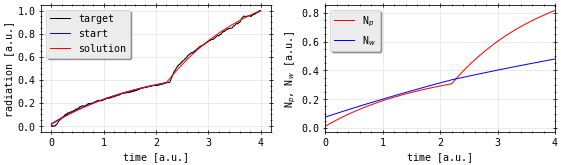

In [12]:
def integrator(x, a, b, c, d, y00, y01):
    N = x[x < a1 - a0].shape[0]
    sol1 = y1_solve(
        x, (a, b, c, d),
        (y00, y01))
    sol2 = y1_solve(
        x[x >= a1 - a0] - x[N],
        (2 * a, b, c, d),
        (sol1[-1, 0], sol1[-1, 1]))

    sol = np.append(
        sol1[:N, 0], sol2[:, 0]- (sol2[0, 0] - sol1[N, 0]))
    return (sol / sol.max())
    
#         Gamma_s   tau_wp   N_wlim      tau_p    N_p0       N_w0
#            a       b          c          d       y00        y01
args = (    .1,      .1,       .5,        .1,      1.,        .0 )
b    = ([   .1,      .1,       .1,        .1,      .0,        .0 ],
        [ np.inf,   np.inf,    np.inf,   np.inf,  np.inf,     .1 ])

T0 = s[(s > a0) & (s < a2)]
V0 = u[(s > a0) & (s < a2)]

L = T0 - T0[0]
G = (V0 - V0[0]) / (V0.max() - V[0])

fig, axes = p.subplots(1, 2)  # sharex=True)
axes[0].plot(L, G, c='k', label='target')
axes[0].plot(
    T - T[0],
    ch2_res * (V.max() - V[0]) / (V0.max() - V[0]),
    c='b', label='start')

res, pcov = curve_fit(
    integrator,
    L, G,
    p0=args, bounds=b,
    maxfev=10000)
# print('res:', res)

ch2_double = integrator(
    T0 - T0[0],
    res[0], res[1], res[2],
    res[3], res[4], res[5])
axes[0].plot(
    L, ch2_double,
    c='r', label='solution')

N = L[L < a1 - a0].shape[0]
s1 = y1_solve(
    L, (res[0], res[1], res[2], res[3]),
    (res[4], res[5]))
s2 = y1_solve(
    L[L >= a1 - a0] - L[N],
    (2 * res[0], res[1], res[2], res[3]),
    (s1[-1, 0], s1[-1, 1]))
s3 = np.array([
    np.append(s1[:N, 0], s2[:, 0] - (s2[0, 0] - s1[N, 0])),
    np.append(s1[:N, 1], s2[:, 1] - (s2[0, 1] - s1[N, 1]))])

axes[1].plot(
    L, s3[0, :], c='r', label='N$_{p}$')
axes[1].plot(
    L, s3[1, :], c='b', label='N$_{w}$')

# title = ''
# for pr, v in zip([
#         '$\Gamma_{s}$', '$\\tau_{w,p}$', '$N_{w,lim}$',
#         '$\\tau_{w,p}$', '$N_{p,0}$', '$N_{w,0}$'], res):
#     title += pr + '=' + format(v, '.2f') + ', '
# fig.suptitle(
#     t=title,
#     x=.5, y=1.)

for ax in axes:
    ax.legend()
axes[0].set_xlabel('time [a.u.]')
axes[1].set_xlabel('time [a.u.]')
axes[0].set_ylabel('radiation [a.u.]')
axes[1].set_ylabel('N$_{p}$, N$_{w}$ [a.u.]')
axes[1].set_xlim(.0, 4.)

fig.set_size_inches(8., 2.5)
fig.savefig('chamber_simulation_two_stage.pdf')
fig.savefig('CURRENT/chamber_simulation.pdf')

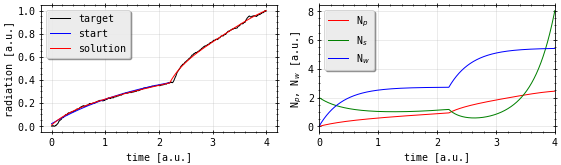

In [14]:
def integrator(x, a, b, c, d, e, f, g, h, y00, y01, y02):
    # solution = y2_solve(
    #     t=x, args=(a, b, c, d, e, f, g),
    #     y0=(y00, y01, y02))
    # L = solution[:, 1]  # + h * solution[:, 0]

    N = x[x < a1 - a0].shape[0]
    sol1 = y2_solve(
        t=x, args=(a, b, c, d, e, f, g),
        y0=(y00, y01, y02))
    sol2 = y2_solve(
        t=x[x >= a1 - a0], args=(2 * a, b, c, d, e, f, g),
        y0=(sol1[-1, 0], sol1[-1, 1], sol1[-1, 2]))

    sol = np.append(
        sol1[:N, 1] + h * sol1[:N, 0],
        sol2[:, 1] - (sol2[0, 1] - sol1[N, 1]) + h * (
            sol2[:, 0] - (sol2[0, 0] - sol1[N, 0])))
    return (sol / np.abs(sol).max())

#       tau_sp   N_plim    tau_ps     Gamma_s   N_wlim      tau_ws     tau_s    fac      N_p0        N_s0     N_w0
#         a        b          c          d         e          f         g        h        y00        y01       y02
p0 = (    1.,      1.,       1.,      10.,         1.,        1.,       5.,      1.,      .0,        .0,        .0    )
b = ([    .1,      .1,       .1,        .1,        .1,        .1,       .1,      .0,      .0,        .0,        .0    ],
     [np.inf,  np.inf,    np.inf,   np.inf,    np.inf,    np.inf,   np.inf,    100.,  np.inf,    np.inf,    np.inf    ])

T1 = s[np.where((s > a0) & (s < a2))[0]]
V1 = u[np.where((s > a0) & (s < a2))[0]]

L = T1 - T1[0]
G = (V1 - V1[0]) / (V1.max() - V1[0])

fig, axes = p.subplots(1, 2)  # , sharex=True)
axes[0].plot(L, G, c='k', label='target')
axes[0].plot(
    T - T[0],
    ch2_res * (V.max() - V[0]) / (V0.max() - V[0]),
    c='b', label='start' )

res, pcov = curve_fit(
    integrator, L, G,
    bounds=b, p0=p0, maxfev=100000)
# print('res:', res)

ch3_res = integrator(
    L, res[0], res[1], res[2], res[3], res[4],
    res[5], res[6], res[7], res[8], res[9], res[10])

axes[0].plot(L, ch3_res, c='r', label='solution')

# L = np.linspace(0.0, 8.0, 101)
N = L[L < a1 - a0].shape[0]
s1 = y2_solve(
    L, (res[0], res[1], res[2], res[3],
        res[4], res[5], res[6]),
    (res[8], res[9], res[10]))
s2 = y2_solve(
    L[L >= a1 - a0] - L[N],
    (2 * res[0], res[1], res[2], res[3],
     res[4], res[5], res[6]),
    (s1[-1, 0], s1[-1, 1], s1[-1, 2]))
ch3_populations = np.array([
    np.append(s1[:N, 0], s2[:, 0] - (s2[0, 0] - s1[N, 0])),
    np.append(s1[:N, 1], s2[:, 1] - (s2[0, 1] - s1[N, 1])),
    np.append(s1[:N, 2], s2[:, 2] - (s2[0, 2] - s1[N, 2]))]).transpose()

axes[1].plot(L, ch3_populations[:, 0], c='r', label='N$_{p}$')
axes[1].plot(L, ch3_populations[:, 1], c='g', label='N$_{s}$')
axes[1].plot(L, ch3_populations[:, 2], c='b', label='N$_{w}$')

# title = ''
# for pr, v in zip([
#         '$\\tau_{s,p}$', '$N_{p,lim}$', '$\\tau_{p,s}$',
#         '$\Gamma_{s}$', '$N_{w,lim}$', '$\\tau_{w,s}$', '$\\tau_{s}$',
#         '$f$', '$N_{p,0}$',  '$N_{s,0}$', '$N_{w,0}$'], res):
#     title += pr + '=' + format(v, '.2f') + ', '
#     if pr == '$\\tau_{w,s}$':
#         title += '\n'
# fig.suptitle(
#     t=title,
#     x=.5, y=1.075)

for ax in axes:
    ax.legend()
axes[0].set_xlabel('time [a.u.]')
axes[1].set_xlabel('time [a.u.]')
axes[0].set_ylabel('radiation [a.u.]')
axes[1].set_ylabel('N$_{p}$, N$_{w}$ [a.u.]')
axes[1].set_xlim(.0, 4.)

fig.set_size_inches(8., 2.5)
fig.savefig('chamber_simulation_two_stage_threechamber.pdf')
fig.savefig('CURRENT/chamber_simulation.pdf')